# Check for gpus

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
# tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#with tf.Session() as sess:
#    print (sess.run(c))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [2]:
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Load the kitti dataset

In [3]:
# Read filenames from text files
with open("/kaggle/input/aaaaaa/kitti/filenames.txt", "r") as f:
    image_paths = ["/kaggle/input/aaaaaa/kitti/" + line.strip().replace("\ufeff", "") for line in f.readlines()]

with open("/kaggle/input/aaaaaa/kitti/gt_filenames.txt", "r") as f:
    depth_paths = ["/kaggle/input/aaaaaa/kitti/" + line.strip().replace("\ufeff", "") for line in f.readlines()]

# Ensure both lists are the same length
assert len(image_paths) == len(depth_paths), "Mismatch between images and ground truth depth maps!"
# print(image_paths)
# Load images and depth maps
def load_image_and_depth(image_path, depth_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    depth = tf.io.read_file(depth_path)
    depth = tf.image.decode_png(depth, channels=1, dtype=tf.uint16)  # GT depth maps are 16-bit

    return image, depth

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, depth_paths))
dataset = dataset.map(lambda img, depth: load_image_and_depth(img, depth))


# Preprocessing

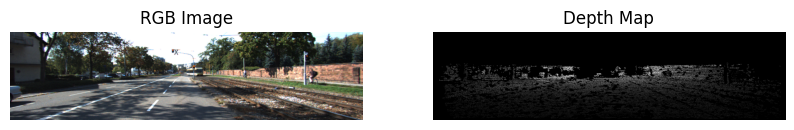

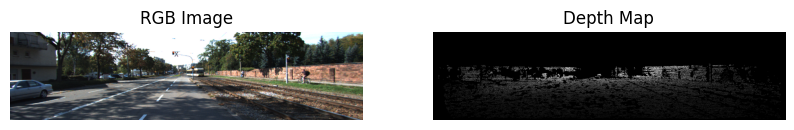

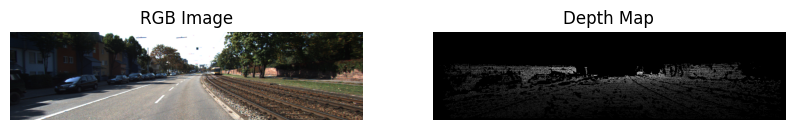

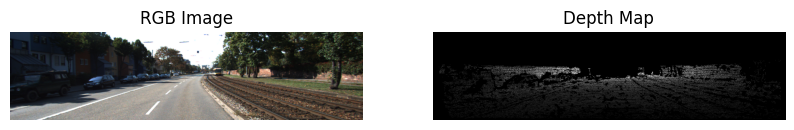

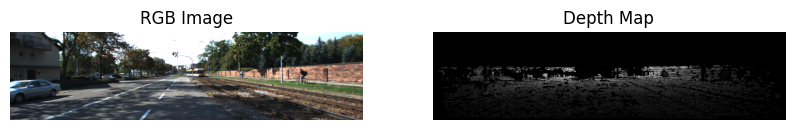

In [4]:
def preprocess(rgb, depth):
    rgb = tf.image.resize(rgb, (256, 1024), method=tf.image.ResizeMethod.BILINEAR)
    depth = tf.image.resize(depth, (256, 1024), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Normalize RGB (Ensure dtype before converting)
    rgb = tf.cast(rgb, tf.float32) / 255.0  # Convert uint8 to float in [0, 1]
    
    # Normalize Depth (Ensure nonzero division)
    depth = tf.cast(depth, tf.float32)
    max_depth = tf.reduce_max(depth)
    depth = depth / max_depth  # Avoid division by zero
    return rgb, depth

def data_generator():
    for img_path, depth_path in zip(image_paths, depth_paths):
        rgb, depth = load_image_and_depth(img_path, depth_path)
        yield preprocess(rgb, depth)

dataset = tf.data.Dataset.from_generator(
    data_generator, output_signature=(
        tf.TensorSpec(shape=(256, 1024, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 1024, 1), dtype=tf.float32)
    )
).shuffle(100)

for image, depth in dataset.take(5):  # Display 5 samples
    image = image.numpy()
    depth = depth.numpy().squeeze()  # Remove channel dimension if needed

    plt.figure(figsize=(10, 5))

    # Show RGB image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("RGB Image")
    plt.axis("off")

    # Show Depth Map
    plt.subplot(1, 2, 2)
    plt.imshow(depth, cmap="gray")
    plt.title("Depth Map")
    plt.axis("off")

    plt.show()

# Model definition

In [5]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.5)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.5)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [6]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(256, 1024,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = None)(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [7]:
unet_model = build_unet_model()
# unet_model.summary()

In [8]:
def scale_invariant_loss(y_true, y_pred):
    diff = y_true - y_pred
    return tf.reduce_mean(diff**2) - 0.5 * (tf.reduce_mean(diff) ** 2)
    
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=scale_invariant_loss,
                   metrics=['mae'])

# Training

In [ ]:
split_index = int(0.8 * len(image_paths))
steps_per_epoch = int(len(image_paths) * 0.8 // 8)  # 80% of data, batch size 8
validation_steps = int(len(image_paths) * 0.2 // 8)  # 20% for validation

train_dataset = dataset.take(split_index).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE).repeat()
val_dataset = dataset.skip(split_index).batch(8).prefetch(tf.data.AUTOTUNE)

model_history = unet_model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,  # Limit training steps per epoch
    validation_data=val_dataset,
    validation_steps=validation_steps  # Limit validation steps
)

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - loss: 0.1302 - mae: 0.1418 - val_loss: 0.0167 - val_mae: 0.0601
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - loss: 0.0098 - mae: 0.0553 - val_loss: 0.0180 - val_mae: 0.0627
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


74/74 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0095 - mae: 0.0550 - val_loss: 0.0166 - val_mae: 0.0576
Epoch 4/5
40/74 ━━━━━━━━━━━━━━━━━━━━ 27s 794ms/step - loss: 0.0096 - mae: 0.0541

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    if 'mae' in history and 'val_mae' in history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['mae'], 'bo-', label='Training MAE')
        plt.plot(epochs, history['val_mae'], 'ro-', label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
    
    plt.show()

plot_training_history(model_history.history)

In [ ]:
val_batch = next(iter(val_dataset))
val_rgb, val_depth = val_batch
pred_depth = unet_model.predict(val_rgb)
num_examples = 3

plt.figure(figsize=(25, 15))
for i in range(num_examples):
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(val_rgb[i].numpy())
    plt.title("Input RGB")
    plt.axis("off")
    
    # Display the ground truth depth map
    gt_depth = val_depth[i].numpy().squeeze()
    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(gt_depth, cmap="gray")
    plt.title(f"Ground Truth (min: {gt_depth.min():.2f}, max: {gt_depth.max():.2f})")
    plt.axis("off")
    
    # Display the predicted depth map with proper normalization
    pred = pred_depth[i].squeeze()
    print(pred.max(), pred.min)
    
    plt.subplot(3, num_examples, 2 * num_examples + i + 1)
    plt.imshow(pred, cmap="gray")
    plt.title(f"Prediction (min: {pred.min():.2f}, max: {pred.max():.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()